In [8]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Dataset

In [9]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


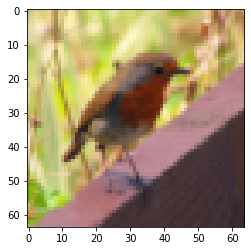

In [10]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [11]:
# Explore dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [12]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## L-layer neural network

In [24]:
# CONSTANTS
layers_dims = [12288, 20, 7, 5, 1] #4-layer model

In [38]:
def initialize_parameters_deep(layers_dims):
    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l],1))

        #Checking dimension
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))
    
    return parameters

In [39]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2 # number of layers in the neural network

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b" + str(l)], 
                                                activation = "relu" )
        caches.append(cache)
        
    # Implement LINEAR -> SIGMOID
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)] , parameters["b" + str(L)] , "sigmoid")
    caches.append(cache) # Add "cache" to the "caches" list

    #Checking dimension
    assert(AL.shape == (1,X.shape[1]))
    
    return AL, caches

In [40]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = - np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL)) / m

    cost = np.squeeze(cost)
    
    assert(cost.shape == ())
    
    return cost

In [41]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # last layer calculation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]

    # putting data of last layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, 
                                                                                                    current_cache, 
                                                                                                    "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+ str(l+1)], current_cache, "relu")
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        grads["dA" + str(l)] = dA_prev_temp
    
    return grads

In [42]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W"+ str(l+1)] - learning_rate * grads["dW"+ str(l+1)]
        parameters["b" + str(l+1)] = parameters["b"+ str(l+1)] - learning_rate * grads["db"+ str(l+1)]
    
    return parameters

In [43]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # gradient descent
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)

        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


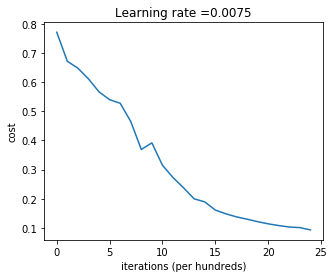

In [44]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [45]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [46]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8
